# 轉折判斷的輔助工具  

## 程式實作：尋找方向變化點函式  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import mplfinance as mpf
import numpy as np

In [2]:
# 來源 ： https://github.com/neurotrader888/TechnicalAnalysisAutomation/blob/main/directional_change.py
from myutils.DirectionalChange import directional_change

In [3]:
def FindingDirectionalChangePoints( prices, percentage=5, mode='default') :
    # 價格資料確認與處理
    if prices is None and type(prices) is not DataFrame:
        return None
    in_prices = prices.copy()
    if 'Open' not in in_prices.columns or 'High' not in in_prices.columns or 'Low' not in in_prices.columns or 'Close' not in in_prices.columns :
        return None    
    if 'Date' not in in_prices.columns and in_prices.index.dtype == 'datetime64[ns]' :
        in_prices.index.name = 'Date'
        in_prices = in_prices.reset_index()
    if 'Date' not in in_prices.columns :
        return None
    # 模式確認與處理
    if mode == 'default' :
        prices_close=np.array(in_prices['Close'])
        prices_high=np.array(in_prices['High'])
        prices_low=np.array(in_prices['Low'])
    elif mode == 'close' :
        prices_close=np.array(in_prices['Close'])
        prices_high=np.array(in_prices['Close'])
        prices_low=np.array(in_prices['Close'])
    # 參數轉換    
    sigma = float(percentage) / 100.0
    # 呼叫directional_change函式    
    tops, bottoms = directional_change( close=prices_close, high=prices_high, low=prices_low, sigma=sigma)
    local_min = np.array(bottoms)
    local_max = np.array(tops)
    local_min_idx = local_min[:,1]
    local_max_idx = local_max[:,1]
    # 合併局部最大(波峰)與局部最小(波谷)轉折點
    local_max_min_point=[]
    total_price = len(prices_close)
    for idx in range(total_price):
        if mode == 'default' :
            if idx in local_max_idx :
                local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],in_prices.iloc[idx]['High'],'HI'))
            elif idx in local_min_idx :
                local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],in_prices.iloc[idx]['Low'],'LO'))
        elif mode == 'close' :
            if idx in local_max_idx :
                local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],in_prices.iloc[idx]['Close'],'HI'))
            elif idx in local_min_idx :
                local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],in_prices.iloc[idx]['Close'],'LO'))
    local_max_min_point = pd.DataFrame(local_max_min_point,columns=['DateIndex','Date','Price','Type'])
    # 轉換為輸出格式
    max_min = local_max_min_point.set_index('DateIndex')
    return local_min_idx,local_max_idx,max_min

#### 以「尋找轉折點方式」做為對照組

In [4]:
##### 使用2022年3月11日2023年7月12日之日線圖資料 #####

# 載入從「好神通PLUS」輸出的Excel檔
df = pd.read_excel('Day10_Day21.xlsx')

# 保存K線的基本資訊(開、高、低、收、量)
df_k_line = df.drop(columns=['SMA5','SMA10','SMA20','SMA60','SMA120','SMA240','ZIGZAG_5%','MA5','MA10'])

# 保存價的移動平均線
df_sma = df.drop(columns=['開盤價','最高價','最低價','收盤價','ZIGZAG_5%','成交量','MA5','MA10'])

# 保存峰谷線
df_zigzag = df.drop(columns=['開盤價','最高價','最低價','收盤價','SMA5','SMA10','SMA20','SMA60','SMA120','SMA240','成交量','MA5','MA10'])

# 將K線的Columns的名稱由中文改為英文
df_k_line = df_k_line.rename(columns={'時間':'Date','開盤價':'Open','最高價':'High','最低價':'Low','收盤價':'Close','成交量':'Volume'})

# 將價的移動平均線的Columns的名稱由中文改為英文
df_sma = df_sma.rename(columns={'時間':'Date'})

# 將峰谷線的Columns的名稱由中文改為英文
df_zigzag = df_zigzag.rename(columns={'時間':'Date'})

# 設定今天日期
today_date = df_k_line.iloc[-1]['Date'].strftime("%Y-%m-%d")

# 將K線的Date設為Index
df_k_line.set_index(df_k_line['Date'],inplace=True)
df_k_line = df_k_line.drop(columns=['Date'])

# 將價的移動平均線的Date設為Index
df_sma.set_index(df_sma['Date'],inplace=True)
df_sma = df_sma.drop(columns=['Date'])

                Date  Price Type
DateIndex                       
8         2022-03-23  47.45   HI
41        2022-05-12  36.15   LO
59        2022-06-08  40.10   HI
76        2022-07-01  26.10   LO
86        2022-07-15  36.05   HI
103       2022-08-09  30.40   LO
115       2022-08-25  36.30   HI
124       2022-09-07  31.50   LO
126       2022-09-12  34.90   HI
154       2022-10-21  27.50   LO
185       2022-12-05  33.40   HI
209       2023-01-09  29.20   LO
232       2023-02-21  32.10   HI
272       2023-04-25  28.30   LO
277       2023-05-03  31.35   HI
294       2023-05-26  28.95   LO
324       2023-07-11  39.25   HI


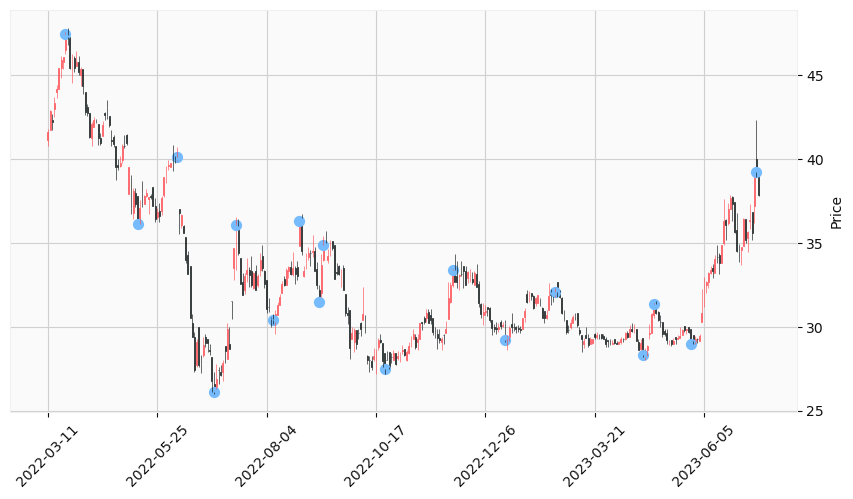

In [5]:
import myutils

# 尋找轉折點：轉折點函式已經整併進myutils套件中(不用重複貼程式碼到這邊)
_,_,max_min = myutils.FindingTurningPoints(df_k_line,'close',order=10)
# 印出轉折點資訊
print(max_min)
# 方向變化點的數量在此設定
n_pips = len(max_min)

# 設定K線格式
mc = mpf.make_marketcolors(up='xkcd:light red', down='xkcd:almost black', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# 設定移動平均線與轉折點    
turning_points_len = len(np.array(df_k_line['Close']))
turning_points = np.array([np.nan]*turning_points_len)
for point in max_min.iterrows() :
    turning_points[point[0]] = point[1]['Price']    
apds = [
    mpf.make_addplot(turning_points,type='scatter',marker='o',markersize=50,color='xkcd:sky blue')
]

# 繪出K線圖與轉折點，以利人眼判斷
kwargs = dict(type='candle', style=s, figratio=(19,10), addplot=apds, datetime_format='%Y-%m-%d')
mpf.plot(df_k_line,**kwargs)

#### 驗證「尋找方向變化點」方式

                Date  Price Type
DateIndex                       
9         2022-03-24  47.80   HI
31        2022-04-27  38.75   LO
36        2022-05-05  41.50   HI
41        2022-05-12  36.10   LO
48        2022-05-23  38.35   HI
49        2022-05-24  36.25   LO
57        2022-06-06  40.85   HI
67        2022-06-20  27.30   LO
69        2022-06-22  30.00   HI
70        2022-06-23  27.25   LO
72        2022-06-27  29.60   HI
76        2022-07-01  26.00   LO
86        2022-07-15  36.55   HI
89        2022-07-20  31.90   LO
98        2022-08-02  34.90   HI
104       2022-08-10  29.60   LO
116       2022-08-26  36.75   HI
124       2022-09-07  31.50   LO
127       2022-09-13  35.70   HI
138       2022-09-28  28.10   LO
144       2022-10-06  32.35   HI
150       2022-10-17  27.20   LO
152       2022-10-19  29.55   HI
154       2022-10-21  27.20   LO
173       2022-11-17  31.05   HI
180       2022-11-28  28.65   LO
186       2022-12-06  34.35   HI
210       2023-01-10  28.65   LO
219       

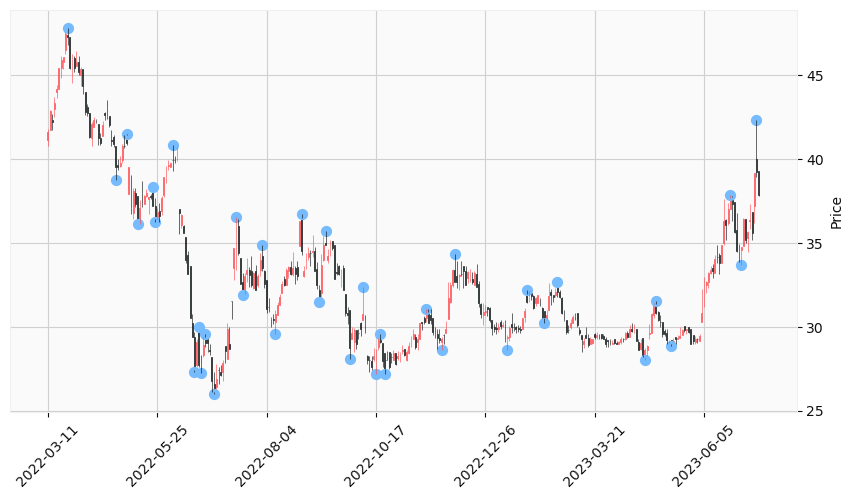

In [6]:
# 尋找方向變化點
_,_,max_min = FindingDirectionalChangePoints(df_k_line)
# 印出方向變化點資訊
print(max_min)

# 設定K線格式
mc = mpf.make_marketcolors(up='xkcd:light red', down='xkcd:almost black', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# 設定移動平均線與方向變化點
turning_points_len = len(np.array(df_k_line['Close']))
turning_points = np.array([np.nan]*turning_points_len)
for point in max_min.iterrows() :
    turning_points[point[0]] = point[1]['Price']    
apds = [
    mpf.make_addplot(turning_points,type='scatter',marker='o',markersize=50,color='xkcd:sky blue')
]

# 繪出K線圖與方向變化點，以利人眼判斷
kwargs = dict(type='candle', style=s, figratio=(19,10), addplot=apds, datetime_format='%Y-%m-%d')
mpf.plot(df_k_line,**kwargs)

## 程式實作：尋找感知重要點函式  

In [7]:
# 來源 ： https://github.com/neurotrader888/TechnicalAnalysisAutomation/blob/main/perceptually_important.py
from myutils.PerceptuallyImportant import find_pips

In [8]:
def FindingPerceptuallyImportantPoints( prices, mode='close', n_pips=5, dist_measure='Perpindicular') :
    # 價格資料確認與處理
    if prices is None and type(prices) is not DataFrame:
        return None
    in_prices = prices.copy()
    if 'Open' not in in_prices.columns or 'High' not in in_prices.columns or 'Low' not in in_prices.columns or 'Close' not in in_prices.columns :
        return None    
    if 'Date' not in in_prices.columns and in_prices.index.dtype == 'datetime64[ns]' :
        in_prices.index.name = 'Date'
        in_prices = in_prices.reset_index()
    if 'Date' not in in_prices.columns :
        return None
    # 模式確認與處理
    if mode == 'close' :
        proc_prices=np.array(in_prices['Close'])
    elif mode == 'open' :
        proc_prices=np.array(in_prices['Open'])
    elif mode == 'high' :
        proc_prices=np.array(in_prices['High'])
    elif mode == 'low' :
        proc_prices=np.array(in_prices['Low'])
    else :
        return None
    # dist_measure
    # 1 = Euclidean Distance
    # 2 = Perpindicular Distance
    # 3 = Vertical Distance
    if dist_measure == 'Euclidean':
        proc_dist_measure = 1
    elif dist_measure == 'Perpindicular':
        proc_dist_measure = 2
    elif dist_measure == 'Vertical':
        proc_dist_measure = 3
    else :
        return None
    pips_x, pips_y = find_pips(data=proc_prices, n_pips=n_pips, dist_measure=proc_dist_measure)
    pips = []
    for i in range(0,len(pips_x)) :
        pips.append((pips_x[i],in_prices.iloc[pips_x[i]]['Date'],pips_y[i]))
    points = pd.DataFrame(pips,columns=['DateIndex','Date','Price'])
     # 轉換為輸出格式
    perceptually_important_points = points.set_index('DateIndex')
    return perceptually_important_points

#### 驗證「尋找感知重要點」方式

                Date  Price
DateIndex                  
0         2022-03-11  41.60
8         2022-03-23  47.45
41        2022-05-12  36.15
59        2022-06-08  40.10
67        2022-06-20  27.40
76        2022-07-01  26.10
86        2022-07-15  36.05
103       2022-08-09  30.40
115       2022-08-25  36.30
124       2022-09-07  31.50
130       2022-09-16  34.70
148       2022-10-13  27.60
185       2022-12-05  33.40
272       2023-04-25  28.30
297       2023-05-31  29.25
312       2023-06-21  37.65
325       2023-07-12  37.85


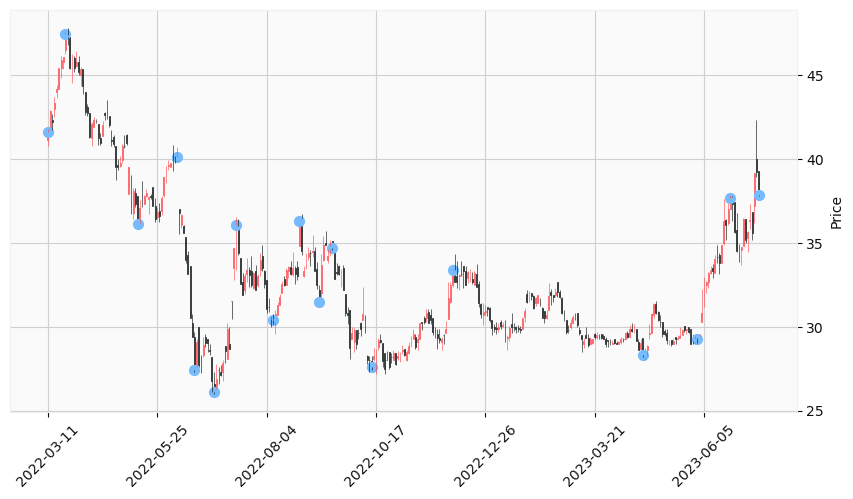

In [9]:
# 尋找方向變化點
max_min = FindingPerceptuallyImportantPoints(df_k_line,n_pips=n_pips)
# 印出方向變化點資訊
print(max_min)

# 設定K線格式
mc = mpf.make_marketcolors(up='xkcd:light red', down='xkcd:almost black', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# 設定移動平均線與方向變化點
turning_points_len = len(np.array(df_k_line['Close']))
turning_points = np.array([np.nan]*turning_points_len)
for point in max_min.iterrows() :
    turning_points[point[0]] = point[1]['Price']    
apds = [
    mpf.make_addplot(turning_points,type='scatter',marker='o',markersize=50,color='xkcd:sky blue')
]

# 繪出K線圖與方向變化點，以利人眼判斷
kwargs = dict(type='candle', style=s, figratio=(19,10), addplot=apds, datetime_format='%Y-%m-%d')
mpf.plot(df_k_line,**kwargs)